In [1]:
import numpy as np
from edhsmm.hsmm_base import GaussianHSMM

In [2]:
# initial parameters (from hsmmlearn tutorial)
def my_init(hsmm_class):
    hsmm_class.pi = np.array([1 / 3, 1 / 3, 1 / 3])
    hsmm_class.dur = np.array([
        [0.1, 0.005, 0.005, 0.89],
        [0.1, 0.005, 0.89, 0.005],
        [0.1, 0.89, 0.005, 0.005]
    ])
    hsmm_class.tmat = np.array([
        [0.0, 0.5, 0.5],
        [0.3, 0.0, 0.7],
        [0.6, 0.4, 0.0]
    ])
    hsmm_class.mean = np.array([[0.0], [5.0], [10.0]])   # shape should be (n_states, n_dim)
    hsmm_class.covmat = np.array([   # shape should be (n_states, n_dim, n_dim) -> array of square matrices
        [[1.]],
        [[1.]],
        [[1.]]
    ])

#### Notes on censoring:
* As I am not a statistician, I honestly am not sure if the usage of terminology is correct.
* Setting `left_censor` to non-zero means that HSMM assumes "left-censoring", which we mean that the beginning of first state *may* happen before the first observation. On the other hand, setting `left_censor` to zero doesn't assume left-censoring, meaning that the beginning of the first state is assumed to have happened *at* the first observation.
* **WARNING:** left-censoring is experimental for now.
* Similarly, setting `right_censor` to non-zero means that HSMM assumes "right-censoring", which we mean that the end of last state *may* happen after the last observation. On the other hand, setting `right_censor` to zero doesn't assume right-censoring, meaning that the end of the last state is assumed to have happened *at* the last observation.
* All functions (`sample()`, `score()`, `predict()`, and `fit()`) support censoring. By default, `left_censor = 0` and `right_censor = 1`.

In [3]:
# initialize HSMM
R = GaussianHSMM(n_states = 3, n_durations = 4)
my_init(R)
# sample observations (from hsmmlearn)
obs = np.array([9.7471989, 9.01877392, -1.28428112, 0.55009463, 0.58425178, 0.43354177,
                10.63374352, 10.14025491, 5.3215164, 5.46421001, 5.16719792, 9.12216889,
                10.49171453, -0.72812025, 0.57309517, 0.3420868, -1.35338431, 4.12587557,
                6.907117, 5.41243634])
obs = obs[:, None]   # shape should be (n_samples, n_dim)
# EM algorithm
R.fit(obs)

FIT: reestimation complete for loop 1.
FIT: reestimation complete for loop 2.
FIT: converged at loop 3.


In [4]:
# log-likelihood of time-series under the model
# note: for HSMMs with continuous emissions like GaussianHSMM, log-likelihoods can be positive.
# in other words, likelihoods can be greater than 1!
R.score(obs)

-25.87422389268414

In [5]:
# Viterbi algorithm
# note: "logl" is different from "score" above. "logl" here is the log-likelihood
# of time-series AND the state sequence (the "states" variable below) under the model
states, logl = R.predict(obs)
# correct states (from hsmmlearn tutorial)
correct = np.array([2,2,0,0,0,0,2,2,1,1,1,2,2,0,0,0,0,1,1,1])
# how many incorrect states?
print(np.sum(states != correct))

0


#### Support for multiple observation sequences!
* For this demo, the `obs` variable is just repeated. Because of this, when `fit()` has `lengths` corresponding
to the `multi_obs` having 2 sequences, the learned HSMM parameters must be close to above.

In [6]:
multi_obs = np.append(obs, obs, axis=0)
multi_len = [len(obs), len(obs)]

In [7]:
# initialize HSMM
S = GaussianHSMM(n_states = 3, n_durations = 4)
my_init(S)
# EM algorithm
S.fit(multi_obs, lengths=multi_len)

FIT: reestimation complete for loop 1.
FIT: reestimation complete for loop 2.
FIT: converged at loop 3.


In [8]:
# do the learned parameters of R and S have close values?
print("Start Probabilities:", np.allclose(R.pi,S.pi))
print("Transition Matrix:", np.allclose(R.tmat,S.tmat))
print("Durations:", np.allclose(R.dur,S.dur))
print("Means:", np.allclose(R.mean,S.mean))
print("Covariance Matrices:", np.allclose(R.covmat,S.covmat))
# display learned parameters for both R and S
print("\n")
print("Start Probabilities: [R]\n", R.pi, "\nStart Probabilities: [S]\n", S.pi, "\n")
print("Transition Matrix: [R]\n", R.tmat, "\nTransition Matrix: [S]\n", S.tmat, "\n")
print("Durations: [R]\n", R.dur, "\nDurations: [S]\n", S.dur, "\n")
print("Means: [R]\n", R.mean, "\nMeans: [S]\n", S.mean, "\n")
print("Covariance Matrices: [R]\n", R.covmat, "\nCovariance Matrices: [S]\n", S.covmat)

Start Probabilities: True
Transition Matrix: True
Durations: True
Means: True
Covariance Matrices: True


Start Probabilities: [R]
 [1.08688135e-69 2.37979076e-22 1.00000000e+00] 
Start Probabilities: [S]
 [1.08688135e-69 2.37979076e-22 1.00000000e+00] 

Transition Matrix: [R]
 [[0.00000000e+00 5.00000000e-01 5.00000000e-01]
 [2.56937871e-19 0.00000000e+00 1.00000000e+00]
 [6.66666667e-01 3.33333333e-01 0.00000000e+00]] 
Transition Matrix: [S]
 [[0.00000000e+00 5.00000000e-01 5.00000000e-01]
 [2.56937871e-19 0.00000000e+00 1.00000000e+00]
 [6.66666667e-01 3.33333333e-01 0.00000000e+00]] 

Durations: [R]
 [[5.07959969e-27 8.67694653e-33 2.74135825e-21 1.00000000e+00]
 [8.41014588e-14 3.83344255e-19 1.00000000e+00 1.10263279e-16]
 [5.61360746e-14 1.00000000e+00 3.12656940e-29 8.27053039e-40]] 
Durations: [S]
 [[5.07959969e-27 8.67694653e-33 2.74135825e-21 1.00000000e+00]
 [8.41014588e-14 3.83344255e-19 1.00000000e+00 1.10263279e-16]
 [5.61360746e-14 1.00000000e+00 3.12656940e-29 8.270530

#### NEW! Support for parallelism with Joblib
* All methods now return something. For `fit()`, it returns `self`, the fitted model.
* There is a new attribute called "name". This is used in displayed messages for monitoring (see image below). This is helpful when models are run in parallel.
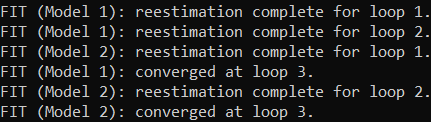

In [9]:
# initialize HSMM
R = GaussianHSMM(n_states = 3, n_durations = 4, name = "Model 1")
my_init(R)
S = GaussianHSMM(n_states = 3, n_durations = 4, name = "Model 2")
my_init(S)

In [10]:
from joblib import Parallel, delayed

models = [R, S]
data = [obs, obs]

# EM algorithm
[R, S] = Parallel(n_jobs=-1)(delayed(i.fit)(j) for i, j in zip(models, data))

# check if models are updated
print(R.tmat)
print(S.tmat)

[[0.00000000e+00 5.00000000e-01 5.00000000e-01]
 [2.56937871e-19 0.00000000e+00 1.00000000e+00]
 [6.66666667e-01 3.33333333e-01 0.00000000e+00]]
[[0.00000000e+00 5.00000000e-01 5.00000000e-01]
 [2.56937871e-19 0.00000000e+00 1.00000000e+00]
 [6.66666667e-01 3.33333333e-01 0.00000000e+00]]


#### Generate observations!
**Notes:**
* If with right censor, the number of samples is exactly equal to given `n_samples`.
* If without right censor, the number of samples will be the GREATEST possible number
  LESS than or equal to the given `n_samples`. A notice will be displayed if `n_samples` is less than the first state duration.
* If with left censor, the first state duration may be cut at the first observation.
* If attributes are not given, the default values are from `_init()`, but since there is no `X` unlike in
  `score()/predict()/fit()`, GaussianHSMM is supplied with the following default values:
 - One (1) for `sample.n_dim`
 - Zeros for `sample.mean`
 - Identity matrices for `sample.covmat`
* `random_state` is used in testing.

In [11]:
R.sample(10, random_state=42)   # exactly 10 samples, with right censor (default)

(10,
 array([[ 1.03277384e+01],
        [ 1.04464911e+01],
        [-7.35883848e-03],
        [-3.65085609e-01],
        [-1.23873452e-01],
        [-7.97500743e-01],
        [ 5.45336526e+00],
        [ 6.31543452e+00],
        [ 5.77950451e+00],
        [ 9.26001830e+00]]),
 array([2, 2, 0, 0, 0, 0, 1, 1, 1, 2]))

In [12]:
R.sample(10, right_censor=0, random_state=42)   # at MOST 10 samples, without right censor

(9,
 array([[ 1.03277384e+01],
        [ 1.04464911e+01],
        [-7.35883848e-03],
        [-3.65085609e-01],
        [-1.23873452e-01],
        [-7.97500743e-01],
        [ 5.45336526e+00],
        [ 6.31543452e+00],
        [ 5.77950451e+00]]),
 array([2, 2, 0, 0, 0, 0, 1, 1, 1]))

### Multinomial HSMM (Discrete Emissions)

In [13]:
from edhsmm.hsmm_multinom import MultinomialHSMM

In [14]:
# modified initial parameters for MultinomialHSMM
def my_init_2(hsmm_class):
    hsmm_class.pi = np.array([1 / 3, 1 / 3, 1 / 3])
    hsmm_class.dur = np.array([
        [0.1, 0.005, 0.005, 0.89],
        [0.1, 0.005, 0.89, 0.005],
        [0.1, 0.89, 0.005, 0.005]
    ])
    hsmm_class.tmat = np.array([
        [0.0, 0.5, 0.5],
        [0.3, 0.0, 0.7],
        [0.6, 0.4, 0.0]
    ])
    hsmm_class.emit = np.array([
        [0.0, 0.3, 0.7],
        [0.6, 0.3, 0.1],
        [0.5, 0.0, 0.5]
    ])   # shape should be (n_states, n_symbols)

In [15]:
# initialize HSMM
T = MultinomialHSMM(n_states = 3, n_durations = 4)
my_init_2(T)
# sample observations (made up by me)
obs = np.array([2, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 0, 0])
obs = obs[:, None]   # shape should be (n_samples, 1)
# EM algorithm
T.fit(obs)

FIT: reestimation complete for loop 1.
FIT: reestimation complete for loop 2.
FIT: reestimation complete for loop 3.
FIT: reestimation complete for loop 4.
FIT: reestimation complete for loop 5.
FIT: converged at loop 6.


In [16]:
# display learned parameters for T
print("Start Probabilities: [T]\n", T.pi, "\n")
print("Transition Matrix: [T]\n", T.tmat, "\n")
print("Durations: [T]\n", T.dur, "\n")
print("Emission Probabilities: [T]\n", T.emit, "\n")

Start Probabilities: [T]
 [1.00000000e+00 6.75140456e-74 4.03018412e-54] 

Transition Matrix: [T]
 [[0.00000000e+00 1.00000000e+00 1.16842736e-42]
 [9.27135767e-45 0.00000000e+00 1.00000000e+00]
 [1.00000000e+00 6.26623255e-13 0.00000000e+00]] 

Durations: [T]
 [[5.00000000e-001 1.90516244e-025 2.32798476e-026 5.00000000e-001]
 [9.54968763e-025 4.41297537e-013 9.99994851e-001 5.14898936e-006]
 [2.79805365e-012 1.00000000e+000 1.55111068e-013 3.27572380e-122]] 

Emission Probabilities: [T]
 [[0.00000000e+00 7.62089478e-26 1.00000000e+00]
 [1.66668097e-01 8.33331903e-01 1.36384978e-19]
 [1.00000000e+00 0.00000000e+00 5.99996043e-23]] 

